# Data Visualization

In [1]:
import os
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')


In [17]:
import datajoint as dj
import datetime
from workflow_array_ephys.pipeline import ephys, probe, ephys_report

## Unit level visualization


In [13]:
# Get the unit key
unit_number = 13

unit_key = {'subject': 'subject6',
 'session_datetime': datetime.datetime(2021, 1, 15, 11, 16, 38),
 'insertion_number': 0,
 'paramset_idx': 0,
 'unit' : unit_number}

ephys.CuratedClustering.Unit & unit_key

subject,session_datetime,insertion_number,paramset_idx,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
subject6,2021-01-15 11:16:38,0,0,13,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,13,mua,13607,=BLOB=,=BLOB=,=BLOB=


### Plot waveform


In [4]:
from element_array_ephys.plotting.unit_level import plot_waveform, plot_auto_correlogram, plot_depth_waveforms

# Fetch unit data
sampling_rate = (ephys.EphysRecording & unit_key).fetch1(
    "sampling_rate") / 1e3  # in kHz

unit_data = (
    (ephys.CuratedClustering.Unit & unit_key) * ephys.WaveformSet.PeakWaveform
).fetch1()

waveform=unit_data["peak_electrode_waveform"]
spike_times=unit_data["spike_times"]

# Fetch unit data
plot_waveform(waveform, sampling_rate)

### Plot autocorrelogram


In [5]:
# Plot Correlogram
plot_auto_correlogram(spike_times=spike_times, bin_size=0.001, window_size=1)

### Plot depth waveforms


In [8]:
# Plot depth Waveforms
plot_depth_waveforms(ephys, unit_key=unit_key, y_range=60)

## Probe level visualization


In [20]:
from element_array_ephys.plotting.probe_level import plot_driftmap

### Plot driftmap


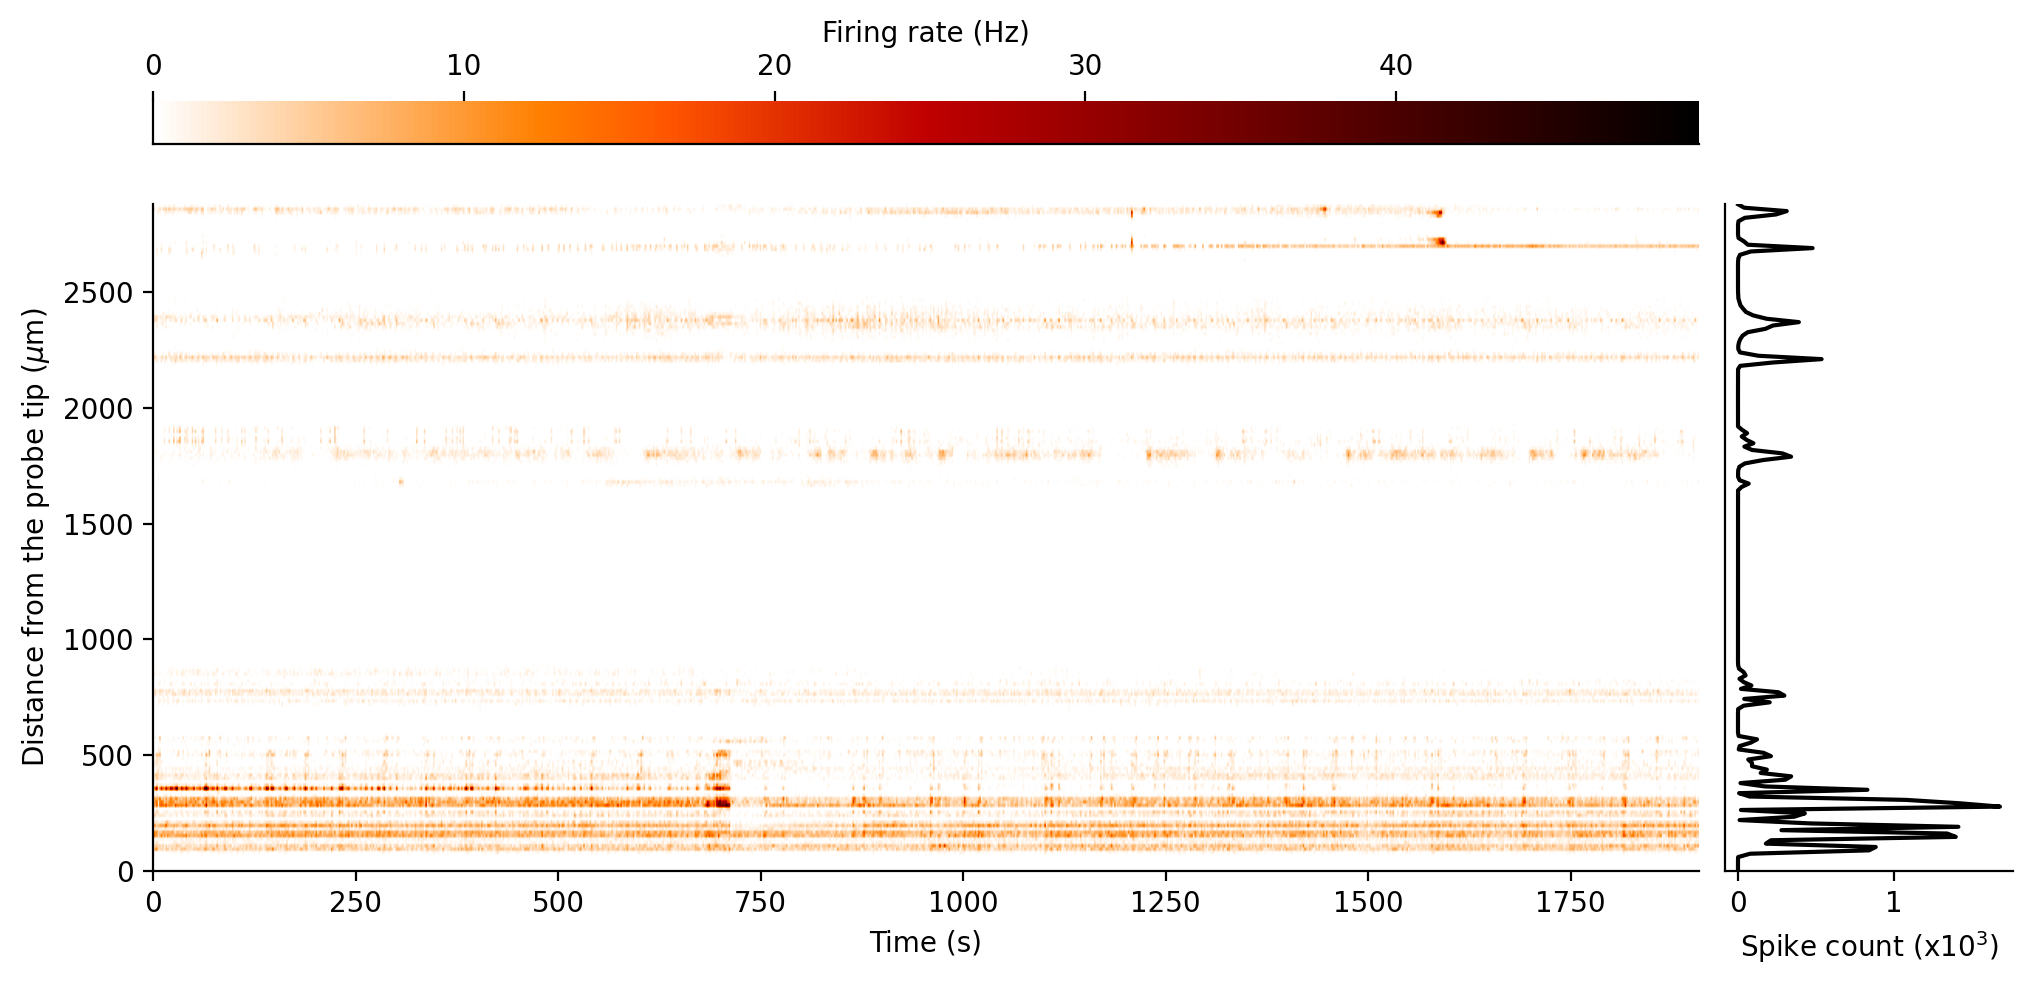

In [21]:
import matplotlib.pyplot as plt

probe_key = {'subject': 'subject6',
 'session_datetime': datetime.datetime(2021, 1, 15, 11, 16, 38),
 'insertion_number': 0,
 'paramset_idx': 0}

# Fetch all units recorded from the probe and specify the shank
units = ephys.CuratedClustering.Unit & probe_key & "cluster_quality_label='good'"
shank_no = 0

table = (
    units
    * ephys.ProbeInsertion.proj()
    * probe.ProbeType.Electrode.proj("shank")
    & {"shank": shank_no}
)

spike_times, spike_depths = table.fetch(
    "spike_times", "spike_depths", order_by="unit"
)

plot_driftmap(spike_times, spike_depths, colormap="gist_heat_r")
plt.show()

## Using ipywidget to visualize all probes & units from the database


In [9]:
from element_array_ephys.plotting.widget import main

main(ephys)